### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 40        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.54450423, 0.25960252, 0.19571401, 0.79537489, 0.15242418,
       0.70519359, 0.48492233, 0.45193437, 0.3696853 , 0.534457  ,
       0.64670386, 0.05742865, 0.56848151, 0.17689606, 0.35943371,
       0.31006234, 0.01100834, 0.51832401, 0.70878659, 0.73641418,
       0.2805132 , 0.65138258, 0.57267109, 0.12017952, 0.97265635,
       0.33696188, 0.52123515, 0.90115009, 0.37825523, 0.25742131,
       0.21943196, 0.38353799, 0.70698116, 0.75515619, 0.5595737 ,
       0.89951561, 0.01741356, 0.69321999, 0.56232838, 0.909583  ])

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.74952304,  0.        ,  0.56624575],
        [ 0.        ,  1.        , -0.51799408],
        [-0.66197826,  0.        ,  0.64113016]],

       [[ 0.76018905,  0.        ,  0.62793178],
        [ 0.        ,  1.        , -0.25669641],
        [-0.64970194,  0.        ,  0.7347167 ]],

       [[ 0.76508227,  0.        ,  0.63163927],
        [ 0.        ,  1.        , -0.19446696],
        [-0.64393254,  0.        ,  0.75047614]],

       [[ 0.56333843,  0.        ,  0.5783725 ],
        [ 0.        ,  1.        , -0.71412609],
        [-0.82622625,  0.        ,  0.39434653]],

       [[ 0.84870083,  0.        ,  0.52274143],
        [ 0.        ,  1.        , -0.15183465],
        [-0.52887324,  0.        ,  0.83886091]],

       [[ 0.93469689,  0.        ,  0.27066704],
        [ 0.        ,  1.        , -0.64818125],
        [-0.35544581,  0.        ,  0.71175868]],

       [[ 0.73510896,  0.        ,  0.59978902],
        [ 0.        ,  1.        , -0.46613964],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.63310978,  0.49073648,  0.44560417],
       [ 0.238486  ,  0.20347229,  0.20155714],
       [ 0.68506042,  0.48208029, -0.00422982],
       [ 0.66126125, -0.06630781, -0.63810319],
       [ 0.22001313,  0.72721753,  0.18509208],
       [ 0.78437036,  0.82463244, -0.2949634 ],
       [ 0.44210018,  0.44689427,  0.39975833],
       [ 0.10717859,  0.20553323,  0.18654144],
       [ 0.99107443,  0.50461696,  0.12056679],
       [ 0.9898942 ,  0.00532113,  0.13803842],
       [ 0.98986582,  0.37232817,  0.22223449],
       [ 1.08515973,  0.10575208,  0.64661297],
       [ 0.99518718,  0.7271967 , -0.25343509],
       [ 0.76985441,  0.09950599, -0.62765826],
       [ 0.34682098,  0.15378308,  0.67676151],
       [ 0.58801391,  0.37210984, -0.02998615],
       [ 0.76908505,  0.50936099,  0.26831456],
       [ 0.35427877,  0.76133387,  0.16827112],
       [ 0.21382194, -0.10736623,  0.14885069],
       [ 0.86716284,  0.42699361,  0.02602787],
       [ 0.2975935 ,  0.26387496,  0.106

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.74198204,  0.97205421,  0.60815826],
       [ 0.60003187,  0.95188957,  0.41550862],
       [ 1.09631747,  0.70778071,  0.25564561],
       [ 1.14850312,  0.71737228, -0.22207026],
       [ 1.24627118,  1.63966358, -0.160794  ],
       [ 0.89934481,  0.57784104, -0.19175508],
       [ 0.68900257,  1.43350978,  0.3739622 ],
       [ 0.47039202,  0.23463099,  0.97532812],
       [ 1.91566956,  0.65550916, -0.12029056],
       [ 1.40927891,  0.67001272,  0.25210678],
       [ 1.35540863,  0.54891714, -0.25867174],
       [ 1.19118275, -0.1562011 ,  0.61440329],
       [ 1.59183385,  0.51299551, -0.22587724],
       [ 1.6287696 ,  0.38571577, -0.09600631],
       [ 1.07873615,  1.10919849,  0.96764298],
       [ 1.19014556,  1.26814897, -0.48481143],
       [ 1.2559269 ,  1.17142048,  0.84340341],
       [ 1.17836338,  0.60687523,  0.30381924],
       [ 0.49959751,  0.05212263,  0.14234554],
       [ 1.36842133,  0.09379934,  0.01160734],
       [ 0.69903775,  1.04419228,  0.080

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.84634712, 0.54272682, 0.69145282],
       [0.10186291, 0.90089928, 0.88269653],
       [0.50211946, 0.80519496, 0.94557616],
       [0.61768899, 0.88222007, 0.3548047 ],
       [0.4096382 , 0.36235753, 0.44681186],
       [0.68383348, 0.72264454, 0.69694644],
       [0.46988458, 0.03741198, 0.65162642],
       [0.10291932, 0.88511244, 0.08478831],
       [0.26532314, 0.38817191, 0.51479161],
       [0.29947597, 0.5893134 , 0.15749675],
       [0.87827728, 0.77383721, 0.21581521],
       [0.14702211, 0.98781774, 0.12828324],
       [0.64520192, 0.996673  , 0.70241924],
       [0.96747659, 0.61627735, 0.88353244],
       [0.70729599, 0.03111498, 0.61237806],
       [0.16790686, 0.75565939, 0.78569245],
       [0.55959891, 0.53256398, 0.37675304],
       [0.24132952, 0.46992589, 0.49585268],
       [0.11953763, 0.0017332 , 0.42814037],
       [0.70073927, 0.81978272, 0.07688443],
       [0.23195689, 0.33846663, 0.76002484],
       [0.76754024, 0.76136657, 0.26462336],
       [0.

In [39]:
theta(φ,θ,ψ)

array([[0.54450423, 0.72345505, 0.7894158 ],
       [0.25960252, 0.70719228, 0.2395608 ],
       [0.19571401, 0.69962725, 0.73774597],
       [0.79537489, 0.97237549, 0.62492927],
       [0.15242418, 0.55727238, 0.63427723],
       [0.70519359, 0.36339098, 0.84145878],
       [0.48492233, 0.74496893, 0.59701792],
       [0.45193437, 0.0171267 , 0.3983671 ],
       [0.3696853 , 0.80161804, 0.95340017],
       [0.534457  , 0.63710224, 0.520089  ],
       [0.64670386, 0.29994233, 0.44757416],
       [0.05742865, 0.182003  , 0.09651839],
       [0.56848151, 0.48726501, 0.72011101],
       [0.17689606, 0.9631822 , 0.5999019 ],
       [0.35943371, 0.29160261, 0.77856293],
       [0.31006234, 0.96234829, 0.73636341],
       [0.01100834, 0.74915249, 0.84267755],
       [0.51832401, 0.07077877, 0.56351765],
       [0.70878659, 0.62766775, 0.94814297],
       [0.73641418, 0.25179855, 0.11281386],
       [0.2805132 , 0.93019496, 0.71031765],
       [0.65138258, 0.18903235, 0.0576197 ],
       [0.

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 0.96139947,  0.02492231, -0.04472132],
       [ 0.75159365,  0.81114065,  0.46538112],
       [ 0.94553264,  0.35010385,  0.21236368],
       [ 0.6158432 ,  0.67673395, -0.29315299],
       [ 0.52831949,  0.18440243,  0.23802266],
       [ 0.87021622,  0.28233524, -0.04705332],
       [ 0.49128721, -0.25763363,  0.56302174],
       [ 0.1304465 ,  0.87640148, -0.02625405],
       [ 0.43361271,  0.25318268,  0.3593949 ],
       [ 0.3326002 ,  0.54284878, -0.04134283],
       [ 0.72447555,  0.60773717, -0.51526027],
       [ 0.18687648,  0.96902514, -0.05287827],
       [ 0.82164546,  0.57426632, -0.23695915],
       [ 1.07924645, -0.11127328, -0.15012568],
       [ 0.72143475, -0.36679651,  0.44325258],
       [ 0.65343187,  0.62435524,  0.44865504],
       [ 0.64421458,  0.33256601, -0.00906531],
       [ 0.43319526,  0.35142016,  0.32001262],
       [ 0.12027421, -0.04932389,  0.42487729],
       [ 0.52112964,  0.77020895, -0.47213672],
       [ 0.4643977 ,  0.16375026,  0.620

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 7.71298914e-01, -2.90626462e-01,  5.66245745e-01],
        [ 6.07273140e-01,  6.02413035e-01, -5.17994081e-01],
        [-1.90571031e-01,  7.43394104e-01,  6.41130165e-01]],

       [[ 7.78051764e-01, -1.83611984e-02,  6.27931779e-01],
        [ 2.29325365e-01,  9.38891276e-01, -2.56696413e-01],
        [-5.84846416e-01,  3.43723782e-01,  7.34716702e-01]],

       [[ 6.50378696e-01, -4.21947131e-01,  6.31639273e-01],
        [ 6.59780697e-01,  7.25859513e-01, -1.94466961e-01],
        [-3.76426599e-01,  5.43220568e-01,  7.50476135e-01]],

       [[ 8.02060938e-01,  1.48941288e-01,  5.78372496e-01],
        [ 4.09537940e-01,  5.67717014e-01, -7.14126087e-01],
        [-4.34714765e-01,  8.09638120e-01,  3.94346532e-01]],

       [[ 7.31214881e-01, -4.38253570e-01,  5.22741433e-01],
        [ 5.85724870e-01,  7.96161173e-01, -1.51834654e-01],
        [-3.49644353e-01,  4.17206417e-01,  8.38860914e-01]],

       [[ 7.94644371e-01, -5.43396428e-01,  2.70667037e-01],
        [ 5.67

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 1.38433087e-01, -4.67990423e-01,  1.97885532e-01],
       [ 5.63338123e-01, -3.06231449e-01,  2.47537428e-01],
       [ 1.81562820e-01, -3.67493020e-01,  2.16521220e-01],
       [ 5.49007998e-01, -5.40914737e-01,  3.89199007e-01],
       [ 4.23766217e-02, -2.10128313e-02, -2.18099074e-02],
       [-3.78529321e-01, -3.79969859e-01,  7.65387608e-01],
       [ 3.01871009e-01, -4.37654122e-01, -1.92550551e-01],
       [-3.23601448e-01, -2.75202834e-03,  4.21528549e-01],
       [ 9.84125803e-02, -3.67594484e-01,  2.26458074e-01],
       [ 3.39680873e-02, -9.70675454e-02,  2.98613010e-01],
       [-1.09679269e-01, -2.42221714e-02,  5.33200741e-01],
       [-6.07080280e-02,  2.92187678e-03,  4.70766136e-02],
       [-1.99201733e-01, -3.78180695e-01,  7.19581414e-01],
       [ 6.39459474e-01, -3.31932189e-01, -4.68686561e-01],
       [-7.63613417e-03,  8.15109183e-02,  4.67815016e-03],
       [ 4.68943669e-01, -5.66752393e-01,  4.44872431e-01],
       [-4.58631686e-02,  1.21857831e-01

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.14292021, -0.59572965,  0.44737255],
       [ 0.14948953, -0.08140642,  0.07831888],
       [ 0.11112033, -0.37055586,  0.32193083],
       [ 0.72814849, -0.83256182,  0.36870041],
       [ 0.04079626, -0.22354155,  0.18659853],
       [-0.2797217 , -0.50069866,  0.45065467],
       [ 0.23427035, -0.39773822,  0.30602045],
       [-0.0684853 , -0.02401504,  0.07872678],
       [ 0.15308461, -0.72371406,  0.54913889],
       [ 0.1669197 , -0.33954809,  0.24441096],
       [-0.03150255, -0.22664539,  0.19740497],
       [ 0.00167577, -0.00228931,  0.00331983],
       [-0.05987167, -0.41281319,  0.32659597],
       [ 0.32963874, -0.31749372,  0.41255496],
       [-0.15960132, -0.2173967 ,  0.15510569],
       [ 0.40229311, -0.50881241,  0.49556891],
       [ 0.16684607, -0.48364852,  0.42779091],
       [-0.1494032 , -0.07677605,  0.14706439],
       [-0.0944499 , -0.82681307,  0.61795398],
       [ 0.04567507, -0.15831081,  0.05519412],
       [ 0.35077777, -0.45644746,  0.459

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[ 1.38433087e+08, -4.67990423e+08,  1.97885532e+08],
       [ 5.63338123e+08, -3.06231449e+08,  2.47537428e+08],
       [ 1.81562820e+08, -3.67493020e+08,  2.16521220e+08],
       [ 5.49007998e+08, -5.40914737e+08,  3.89199007e+08],
       [ 4.23766217e+07, -2.10128313e+07, -2.18099074e+07],
       [-3.78529321e+08, -3.79969859e+08,  7.65387608e+08],
       [ 3.01871009e+08, -4.37654122e+08, -1.92550551e+08],
       [-3.23601448e+08, -2.75202834e+06,  4.21528549e+08],
       [ 9.84125803e+07, -3.67594484e+08,  2.26458074e+08],
       [ 3.39680873e+07, -9.70675454e+07,  2.98613010e+08],
       [-1.09679269e+08, -2.42221714e+07,  5.33200741e+08],
       [-6.07080280e+07,  2.92187678e+06,  4.70766136e+07],
       [-1.99201733e+08, -3.78180695e+08,  7.19581414e+08],
       [ 6.39459474e+08, -3.31932189e+08, -4.68686561e+08],
       [-7.63613417e+06,  8.15109183e+07,  4.67815016e+06],
       [ 4.68943669e+08, -5.66752393e+08,  4.44872431e+08],
       [-4.58631686e+07,  1.21857831e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 1.30414756e+08, -1.49050918e+08, -4.43731882e+08],
       [ 1.62083680e+08, -8.19495372e+07, -4.70245823e+08],
       [ 2.77573005e+08, -5.56754270e+07, -3.27253228e+08],
       [-1.74084948e+07, -5.40548449e+08, -7.26705912e+08],
       [-5.67254029e+05,  2.91839783e+07, -2.92195794e+07],
       [-6.99373142e+06, -8.10645953e+08, -4.05896775e+08],
       [-6.38078885e+07,  1.55556466e+08, -4.53603896e+08],
       [-6.51489168e+07, -3.06510710e+08, -5.20150059e+07],
       [ 2.33179472e+08, -1.68161786e+08, -3.74299475e+08],
       [ 1.15198624e+08, -2.06368558e+08, -8.01866142e+07],
       [ 1.97680977e+07, -4.02172208e+08, -1.42035318e+07],
       [ 8.06075845e+06, -8.60208331e+06,  1.09287168e+07],
       [ 1.73793438e+08, -6.19713303e+08, -2.77583120e+08],
       [-3.38250759e+08,  3.97291581e+08, -7.42866438e+08],
       [-4.83923241e+07, -7.13196802e+06,  4.52749432e+07],
       [ 4.11149329e+08, -2.66165058e+08, -7.72481129e+08],
       [-1.51320933e+08,  3.26400694e+07

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 8.55121803e+10,  3.14542341e+10,  1.45668318e+10],
       [ 3.47774833e+10,  6.45697882e+10,  7.34505666e+08],
       [ 6.15726646e+10,  5.56160029e+10,  4.27634126e+10],
       [ 8.09507149e+10,  5.26097192e+10, -4.10720922e+10],
       [ 4.60925519e+10,  4.60967120e+10,  4.51457304e+10],
       [ 8.86897406e+10, -1.82026829e+10,  3.48257486e+10],
       [ 7.14555543e+10,  4.66675213e+10,  5.95234445e+09],
       [ 4.58005533e+10, -1.56842814e+10,  3.50580330e+10],
       [ 8.95856153e+10,  4.57133576e+10,  3.52719882e+10],
       [ 6.95848297e+10,  3.72182512e+10,  4.18274045e+09],
       [ 7.23370189e+10,  3.02524350e+09,  1.50171383e+10],
       [ 7.39211208e+09,  1.76463126e+10,  8.43731453e+09],
       [ 7.86454303e+10,  9.95910793e+09,  2.70054895e+10],
       [ 5.85832660e+10,  8.57614506e+10,  1.91911592e+10],
       [ 5.53783726e+10,  1.77476177e+09,  5.94709900e+10],
       [ 7.52630598e+10,  7.37670556e+10,  1.46413206e+10],
       [ 5.81905183e+10,  7.39876203e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 0.00000000e+00, -7.12692808e-06,  1.52587891e-05],
       [ 5.96046448e-07, -2.58221042e-07, -3.81469727e-06],
       [ 0.00000000e+00,  6.91851662e-06, -1.14440918e-05],
       [ 0.00000000e+00,  2.74523243e-06, -7.62939453e-06],
       [ 0.00000000e+00,  2.58522511e-06,  0.00000000e+00],
       [-1.90734863e-06,  8.43447383e-06,  9.53674316e-06],
       [-4.76837158e-07, -3.66095742e-07,  0.00000000e+00],
       [ 9.53674316e-07,  5.06654089e-06,  9.53674316e-07],
       [-3.81469727e-06,  7.63688908e-06,  0.00000000e+00],
       [ 1.43051147e-06, -3.03504578e-06,  3.81469727e-06],
       [ 4.76837158e-07,  1.54080347e-07, -2.38418579e-06],
       [ 0.00000000e+00,  1.81356754e-07, -2.38418579e-07],
       [ 9.53674316e-07, -3.61598879e-06, -1.90734863e-06],
       [ 5.72204590e-06, -2.16057205e-06, -7.62939453e-06],
       [-3.69548798e-06, -5.10664318e-06,  3.57627869e-06],
       [-1.33514404e-05,  1.18876062e-05,  0.00000000e+00],
       [ 7.62939453e-06, -9.66168055e-06

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[4.27413745e+03, 3.05952992e+02, 4.02295951e+03],
       [9.56651388e+02, 1.17707342e+03, 5.55186860e+02],
       [4.05799762e+03, 2.71563387e+03, 4.57039389e+03],
       [4.86599425e+03, 7.36396438e+02, 2.37176559e+02],
       [5.57118646e+02, 3.16843256e+03, 8.98008735e+02],
       [1.64912363e+03, 1.26653466e+01, 2.08177252e+03],
       [2.33853727e+03, 1.36098035e+02, 1.27305124e+02],
       [2.02890089e+03, 1.35357665e+03, 1.66729718e+03],
       [2.60974584e+03, 1.05898819e+03, 1.17079564e+03],
       [3.42497074e+03, 8.83000131e+02, 4.40213025e+03],
       [5.13962646e+02, 2.05580737e+03, 2.54968684e+03],
       [1.41589722e+03, 1.76408294e+03, 3.19126962e+03],
       [6.82875507e+01, 1.79588345e+03, 8.28785744e+02],
       [1.17289347e+03, 2.77331568e+03, 3.51853288e+03],
       [1.96831773e+03, 5.02629978e+03, 2.75423935e+02],
       [4.05386905e+01, 2.47512912e+03, 2.92125660e+03],
       [2.10226547e+03, 3.56302923e+03, 1.94239112e+03],
       [1.42920554e+03, 4.19782

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])   

In [56]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [57]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [58]:
sigma(x,y,z)

array([[ 3850.27275283,  3850.27275283, 11215.32418506],
       [ 3850.27275283,  3850.27275283, 13252.36804177],
       [ 3850.27275283,  3850.27275283, 13922.13418608],
       [ 3850.27275283,  3850.27275283,  7629.49644411],
       [ 3850.27275283,  3850.27275283,  8609.51622581],
       [ 3850.27275283,  3850.27275283, 11273.83973955],
       [ 3850.27275283,  3850.27275283, 10791.11085172],
       [ 3850.27275283,  3850.27275283,  4753.40058577],
       [ 3850.27275283,  3850.27275283,  9333.60662164],
       [ 3850.27275283,  3850.27275283,  5527.85891937],
       [ 3850.27275283,  3850.27275283,  6149.04141955],
       [ 3850.27275283,  3850.27275283,  5216.6894353 ],
       [ 3850.27275283,  3850.27275283, 11332.13362709],
       [ 3850.27275283,  3850.27275283, 13261.27184519],
       [ 3850.27275283,  3850.27275283, 10373.0546262 ],
       [ 3850.27275283,  3850.27275283, 12219.12320631],
       [ 3850.27275283,  3850.27275283,  7863.28048107],
       [ 3850.27275283,  3850.2

In [59]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T

In [60]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-4.27413745e+03, -3.05952992e+02, -4.15112406e+03],
       [-9.56651388e+02, -1.17707342e+03, -6.83351402e+02],
       [-4.05799762e+03, -2.71563387e+03, -4.69855843e+03],
       [-4.86599425e+03, -7.36396438e+02, -3.65341101e+02],
       [-5.57118646e+02, -3.16843256e+03, -1.02617328e+03],
       [-1.64912363e+03, -1.26653466e+01, -2.20993707e+03],
       [-2.33853727e+03, -1.36098035e+02, -2.55469666e+02],
       [-2.02890089e+03, -1.35357665e+03, -1.79546172e+03],
       [-2.60974584e+03, -1.05898819e+03, -1.29896019e+03],
       [-3.42497074e+03, -8.83000131e+02, -4.53029480e+03],
       [-5.13962646e+02, -2.05580737e+03, -2.67785139e+03],
       [-1.41589722e+03, -1.76408294e+03, -3.31943417e+03],
       [-6.82875507e+01, -1.79588345e+03, -9.56950286e+02],
       [-1.17289347e+03, -2.77331568e+03, -3.64669743e+03],
       [-1.96831773e+03, -5.02629978e+03, -4.03588477e+02],
       [-4.05386905e+01, -2.47512912e+03, -3.04942115e+03],
       [-2.10226547e+03, -3.56302923e+03

In [61]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [62]:
RET = Ret(φ, θ, ψ)

In [63]:
Jrho(RET,Jrho0)

array([[[ 2.02592300e+01,  4.42650453e+01,  1.31336197e+02],
        [ 1.03164770e+02, -5.83735671e+01, -6.32383816e+01],
        [ 6.00943706e+00,  1.45644005e+02,  3.29111995e+01]],

       [[-1.33333442e+01,  4.00145040e+01,  1.41598061e+02],
        [ 6.93994544e+01,  7.00840816e+01, -4.74207623e+01],
        [-1.23560906e+02,  8.38536947e+01,  6.24140952e+01]],

       [[-3.30931770e+01,  1.05539126e+01,  1.44091990e+02],
        [ 1.05442048e+02,  3.72025548e+00, -1.62979220e+00],
        [-4.51411754e+01,  1.36848209e+02,  7.83024583e+01]],

       [[ 2.01444729e+01,  1.14056133e+02,  8.13685504e+01],
        [ 1.18185835e+02, -7.73067690e+01, -7.31782341e+01],
        [-3.59946725e+01,  1.03345433e+02, -5.18592391e+01]],

       [[-8.75679929e+00, -2.33195849e+01,  1.32579311e+02],
        [ 1.00079840e+02,  2.50483814e+01, -6.94385126e+00],
        [-5.97902943e+01,  1.18535275e+02,  1.16125528e+02]],

       [[ 4.39250292e+01, -3.45527603e+01,  9.52602641e+01],
        [ 4.60

### Static solution

In [64]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [65]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [66]:
Fx_0 = 82945396 
Fy_0 = 82945396 

In [67]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [68]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [69]:
delta_x=horizontal_length/(N-1)

In [70]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [71]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [72]:
length_p1

[0,
 107.54461667325299,
 215.08939369389213,
 322.63449140954265,
 430.180070168308,
 537.7262903190086,
 645.2733122114217,
 752.8212961965196,
 860.3704026267086,
 967.9207918560692,
 1075.4726242405948,
 1183.0260601384296,
 1290.581259910109,
 1398.1383839187988,
 1505.6975925305333,
 1613.2590461144548,
 1720.8229050430532,
 1828.3893296924043,
 1935.9584804424096,
 2043.530517677036,
 2151.105601784552,
 2258.6838931577718,
 2366.2655521942884,
 2473.850739296718,
 2581.439614872937,
 2689.032339336321,
 2796.629073105983,
 2904.229976607017,
 3011.8352102707295,
 3119.444934534887,
 3227.05930984395,
 3334.6784966493137,
 3442.302655409547,
 3549.9319465906315,
 3657.566530666202,
 3765.2065681177855,
 3872.8522194350376,
 3980.503645115987,
 4088.161005667269,
 4195.82446160437]

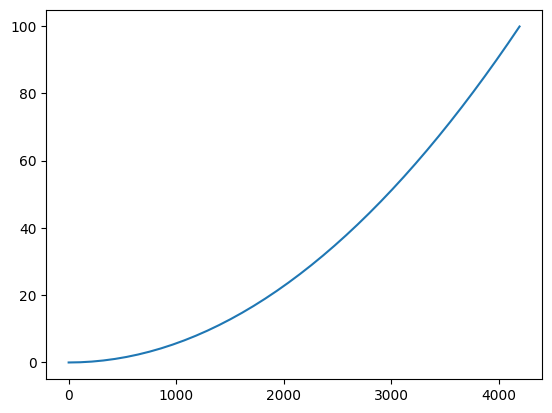

In [73]:
plt.plot(x0, z0)
plt.show()

In [74]:
q0=np.zeros(12*N)

In [75]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [76]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [77]:
root_ = root(static_func, q0, method='df-sane')

In [78]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.202e+02  1.202e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.253e+03  2.360e+03 ...  0.000e+00  0.000e+00]
     nit: 462
    nfev: 1000
  method: df-sane

In [79]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [80]:
# q0 = root_.x                                            # start from static solution

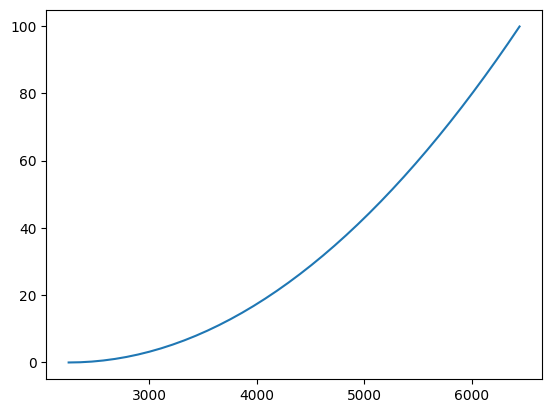

In [81]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [82]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [83]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [84]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [85]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [86]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [87]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [88]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [89]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

#     bc_node = list(range(6))+list(range((len(X)-6),len(X)))
#     bc_val = [0]*6 + vessel_movement
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
#     vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [90]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [91]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.79966264e-09, -8.70059580e-11,  4.99269959e-10],
       [-2.56022759e-10, -8.16852364e-10,  4.52473614e-10],
       [-2.41243470e-10, -1.24734140e-10,  2.68833844e-10],
       [ 5.41149348e-11,  1.41724854e-09,  2.88679303e-10],
       [ 1.58615876e-09, -1.50893698e-09, -2.82483370e-10],
       [ 6.18456397e-10, -2.83961299e-10, -7.72047315e-10],
       [ 3.05590220e-10,  2.85704412e-10,  1.55398538e-09],
       [ 2.45199772e-09, -9.19499143e-10, -4.45083970e-10],
       [ 8.73114914e-11, -1.00072839e-09, -6.28460839e-10],
       [-2.03726813e-10, -3.80424581e-10,  7.14862836e-10],
       [-2.33558239e-09,  6.90907484e-10, -1.92130756e-10],
       [-4.43833414e-10,  9.67759206e-11,  4.60232741e-10],
       [-5.89352567e-10,  2.63980837e-10, -4.14047463e-10],
       [-5.67524694e-10,  1.78147275e-10, -1.81671567e-10],
       [-1.90630089e-09, -1.02864767e-09, -1.93267624e-12],
       [ 8.12633516e-10,  1.31251454e-10

In [92]:
mom

array([[-2.98712544e-09, -1.64433052e-08, -1.26658506e-09],
       [-2.96785174e-09, -2.49590357e-08,  5.13353249e-10],
       [-2.97603719e-09,  2.53551207e-08,  1.07547748e-10],
       [-2.82170731e-09,  1.57342583e-08, -3.40605766e-10],
       [-2.61384159e-09, -2.91670972e-08,  3.31965566e-10],
       [-2.03873185e-09, -1.98451744e-09, -1.96655803e-10],
       [-2.13796625e-09,  2.70096052e-08, -3.33784556e-10],
       [-1.31893785e-09, -1.06692823e-08,  4.54974725e-10],
       [-8.61177796e-11, -2.05874358e-08, -5.82986104e-10],
       [ 6.91372293e-10,  1.76487447e-08,  1.24503963e-10],
       [ 2.86826207e-09,  1.06775726e-08,  2.71029421e-10],
       [ 4.56407179e-09, -2.10147846e-08,  3.88126864e-10],
       [ 6.06772232e-09, -1.33297107e-09,  6.91215973e-11],
       [ 6.96192615e-09,  1.64754965e-08, -1.81454851e-11],
       [ 6.70769396e-09, -2.50634002e-09,  5.22049959e-10],
       [ 4.76374851e-09, -1.01281330e-08, -5.96742211e-10],
       [ 1.76075332e-09,  1.73315584e-09

In [93]:
angle

array([[ 0.01053293, -0.01697935, -0.01461789],
       [ 0.01053291, -0.0167887 , -0.01458858],
       [ 0.01053284, -0.01623372, -0.01450064],
       [ 0.01053266, -0.01534836, -0.01435407],
       [ 0.01053232, -0.01416658, -0.01414887],
       [ 0.01053176, -0.01272233, -0.01388504],
       [ 0.01053094, -0.01104956, -0.01356258],
       [ 0.01052979, -0.00918222, -0.01318148],
       [ 0.01052827, -0.00715428, -0.01274175],
       [ 0.01052631, -0.00499967, -0.01224338],
       [ 0.01052387, -0.00275236, -0.01168637],
       [ 0.01052089, -0.0004463 , -0.01107072],
       [ 0.01051732,  0.00188455, -0.01039642],
       [ 0.01051311,  0.00420624, -0.00966346],
       [ 0.01050819,  0.00648479, -0.00887186],
       [ 0.01050252,  0.00868626, -0.00802159],
       [ 0.01049605,  0.01077666, -0.00711266],
       [ 0.01048871,  0.01272202, -0.00614506],
       [ 0.01048046,  0.01448838, -0.00511878],
       [ 0.01047123,  0.01604175, -0.00403382],
       [ 0.01046099,  0.01734814, -0.002

### Vessle Simulation

In [94]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [95]:
Number*sampleTime

100.0

In [96]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [97]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [98]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

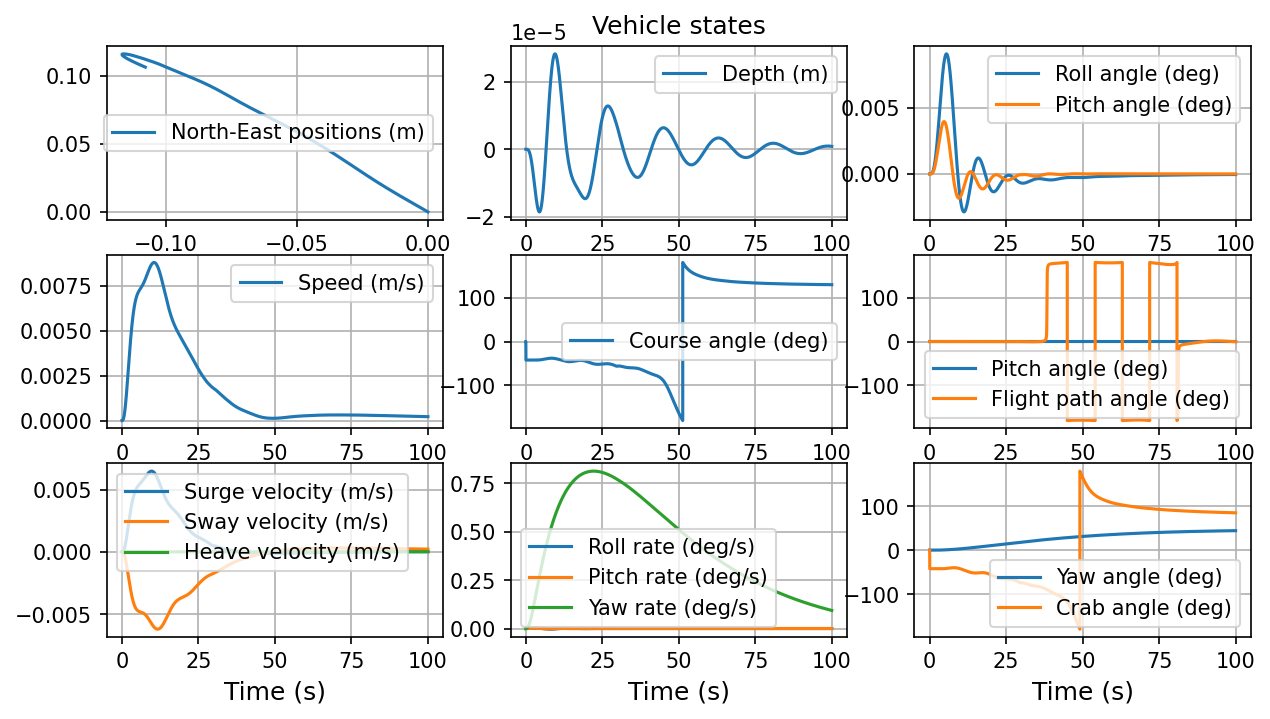

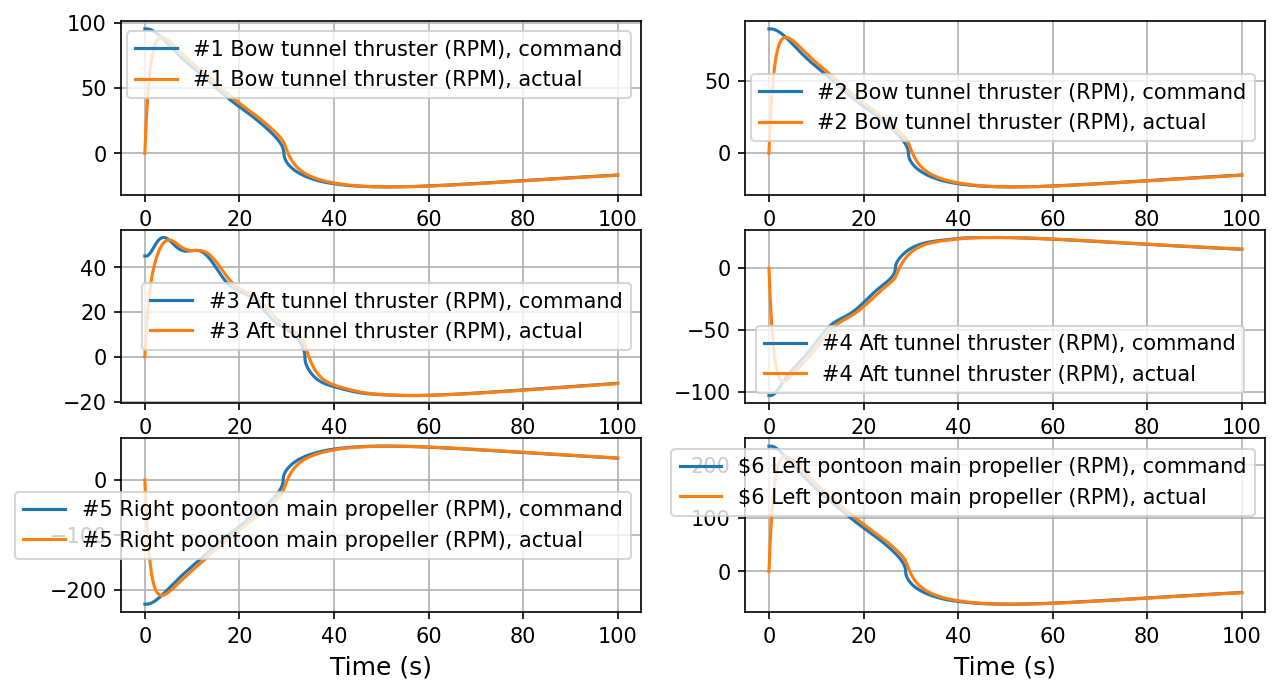

In [99]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [100]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

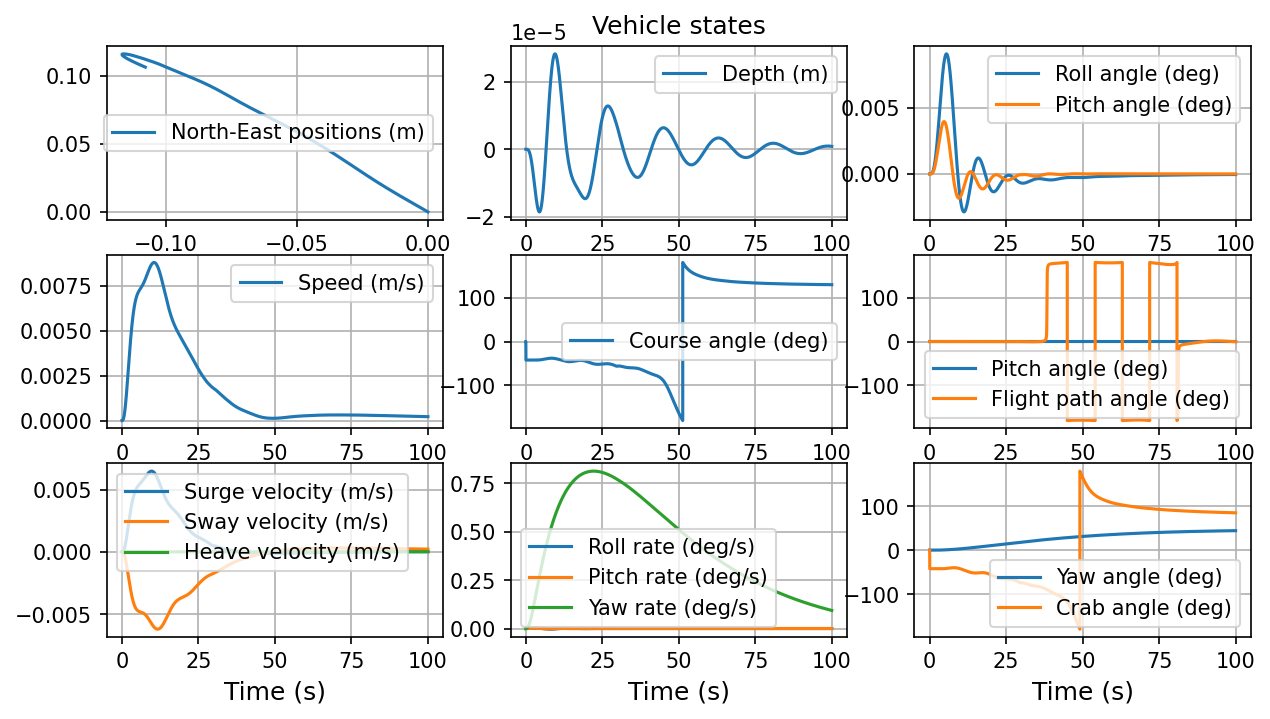

In [101]:
plotVehicleStates(simTime, simData, 3)

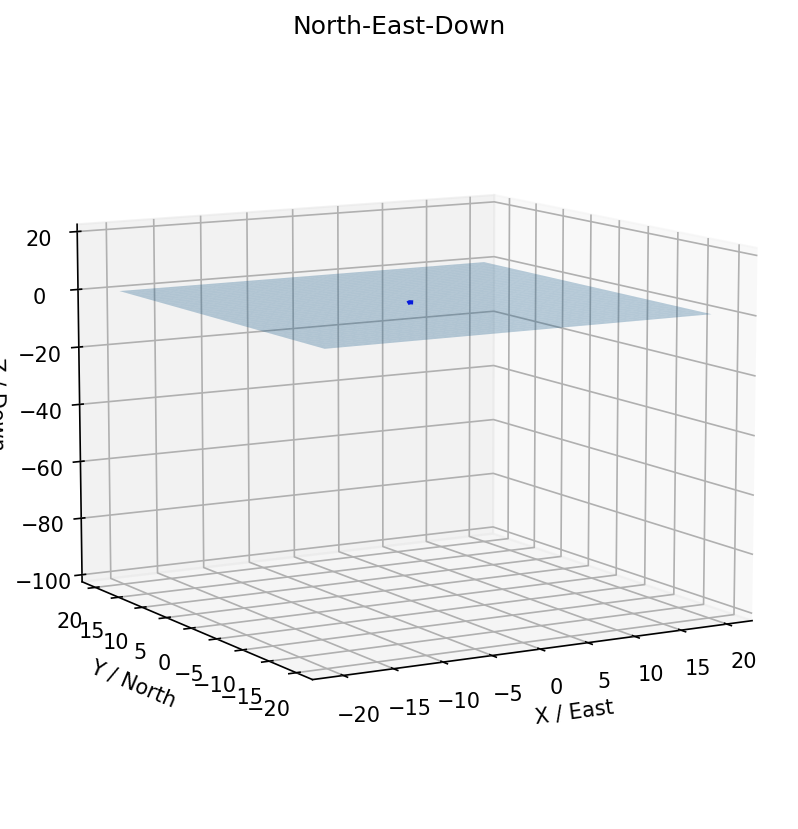

In [102]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [103]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [104]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [105]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [106]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [107]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [108]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = np.radians(phi_ve - T.phi_ve)
    vessel_movement[4] = np.radians(theta_ve - T.theta_ve)
    vessel_movement[5] = np.radians(psi_ve - T.psi_ve)
    vessel_movement/=calibr
    
    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
    
    return ans

In [109]:
# integration parameters
tspan = (0., 50)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.000236*i/N for i in range(N)]))

In [110]:
vessel_motion_calibration_coefficient = 1

In [111]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  1.0098606971295598e-07  Iteration wall clock time:  0:00:00.928572
Physical time:  1.013033518437812  Iteration wall clock time:  0:01:06.065953
Physical time:  2.0105401974269723  Iteration wall clock time:  0:00:22.944996
Physical time:  3.0435819011190994  Iteration wall clock time:  0:00:24.115409
Physical time:  4.015922676615547  Iteration wall clock time:  0:00:27.980195
Physical time:  5.052981019883009  Iteration wall clock time:  0:00:31.324446
Physical time:  6.01021181587266  Iteration wall clock time:  0:00:27.769225
Physical time:  7.000097370591134  Iteration wall clock time:  0:00:28.527431
Physical time:  8.014614639960206  Iteration wall clock time:  0:00:27.909455
Physical time:  9.00728635840166  Iteration wall clock time:  0:00:27.371955
Physical time:  10.047544043434877  Iteration wall clock time:  0:00:29.304557
Physical time:  11.031525235583281  Iteration wall clock time:  0:00:27.972017
Physical time:  12.032749594065674  Iteration wall clock 

### Results

In [112]:
fin=us_

In [113]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.010e-05 ...  4.990e+01  5.000e+01]
        y: [[ 0.000e+00  6.262e-27 ... -3.464e-03 -3.489e-03]
            [ 1.075e+02  1.075e+02 ...  1.075e+02  1.075e+02]
            ...
            [ 0.000e+00 -1.518e-20 ... -3.204e-08 -3.150e-08]
            [ 0.000e+00 -1.159e-20 ... -3.467e-08 -3.409e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 2894
     njev: 0
      nlu: 0

In [114]:
t=fin.t

In [115]:
fin=fin.y.T

In [116]:
t.shape, fin.shape

((463,), (463, 480))

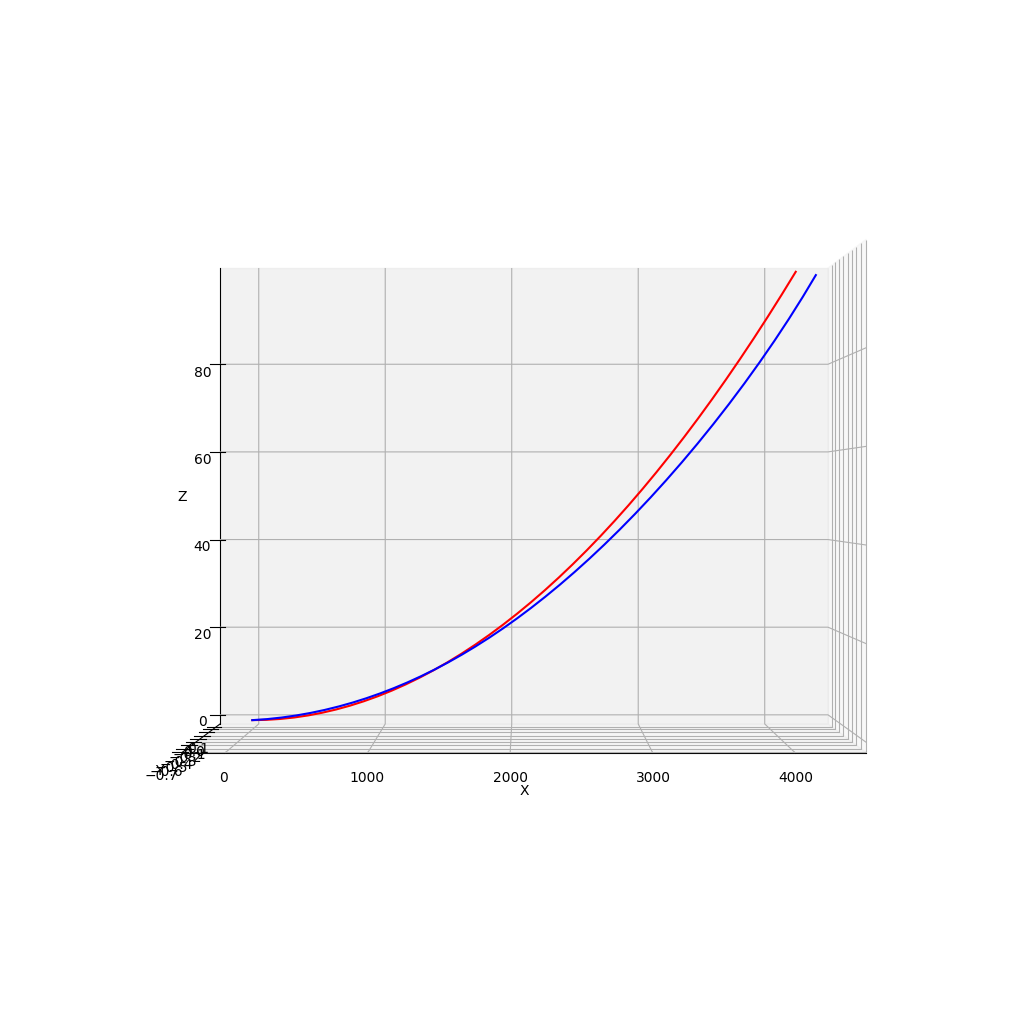

In [117]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [118]:
X,Y,Z

(array([-3.48894684e-03,  1.07457131e+02,  2.14937306e+02,  3.22429197e+02,
         4.29929920e+02,  5.37438828e+02,  6.44956690e+02,  7.52485352e+02,
         8.60027077e+02,  9.67583002e+02,  1.07515121e+03,  1.18272671e+03,
         1.29030417e+03,  1.39787997e+03,  1.50545255e+03,  1.61302156e+03,
         1.72058747e+03,  1.82815084e+03,  1.93571193e+03,  2.04327138e+03,
         2.15082948e+03,  2.25838651e+03,  2.36594284e+03,  2.47349870e+03,
         2.58105413e+03,  2.68860948e+03,  2.79616485e+03,  2.90372052e+03,
         3.01127647e+03,  3.11883275e+03,  3.22638965e+03,  3.33394742e+03,
         3.44150590e+03,  3.54906543e+03,  3.65662585e+03,  3.76418750e+03,
         3.87175057e+03,  3.97931467e+03,  4.08688033e+03,  4.19444723e+03]),
 array([-8.67910587e-07,  2.53538239e-02,  4.95830986e-02,  7.15634452e-02,
         9.08272352e-02,  1.06971428e-01,  1.19653319e-01,  1.28587694e-01,
         1.33543512e-01,  1.34342024e-01,  1.30855844e-01,  1.23009240e-01,
         1

In [119]:
X0,Y0,Z0

(array([   0.        ,  107.54459663,  215.08919326,  322.63378989,
         430.17838652,  537.72298315,  645.26757978,  752.81217641,
         860.35677304,  967.90136967, 1075.4459663 , 1182.99056293,
        1290.53515956, 1398.07975619, 1505.62435282, 1613.16894945,
        1720.71354608, 1828.25814271, 1935.80273934, 2043.34733597,
        2150.8919326 , 2258.43652923, 2365.98112586, 2473.52572249,
        2581.07031912, 2688.61491575, 2796.15951238, 2903.70410901,
        3011.24870564, 3118.79330227, 3226.3378989 , 3333.88249552,
        3441.42709215, 3548.97168878, 3656.51628541, 3764.06088204,
        3871.60547867, 3979.1500753 , 4086.69467193, 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.00000000e+00, 6.56591421e-02, 2.62636666e-01, 5.90932866e-01,
        1.05054823e+00, 1.64148345e+00, 2.36373939e+00, 3.21

In [120]:
us=fin.T

In [121]:
us.shape

(480, 463)

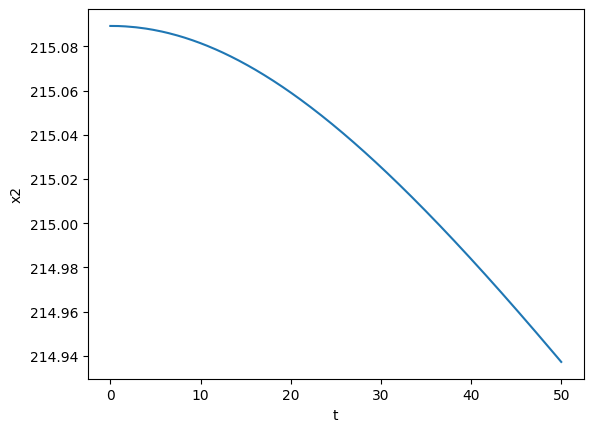

In [122]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

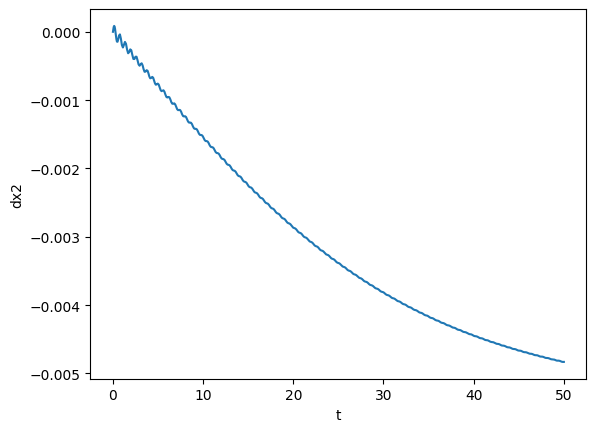

In [123]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

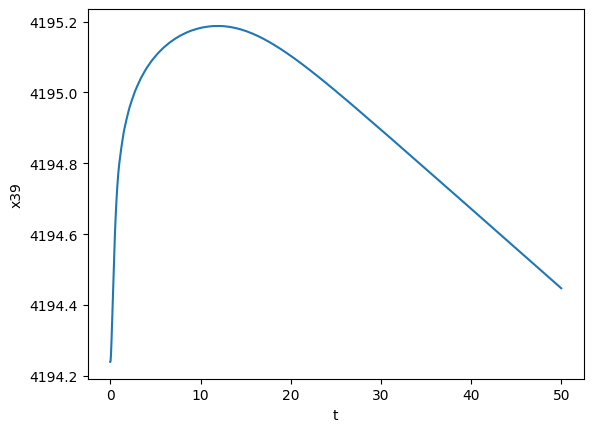

In [124]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

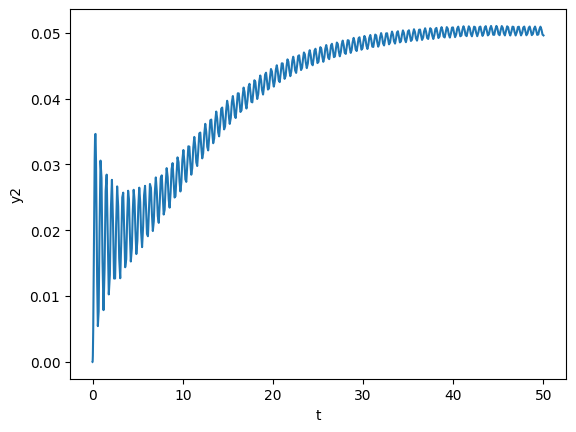

In [125]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

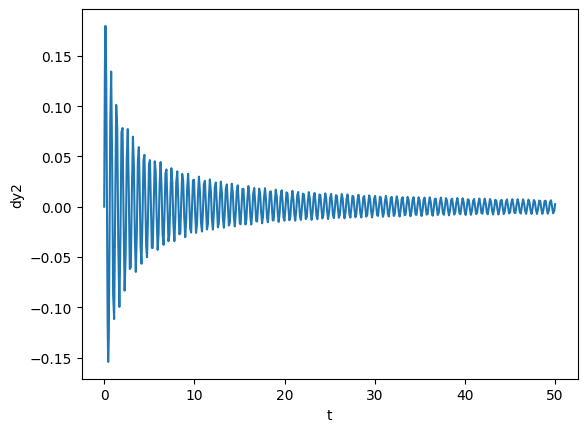

In [126]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

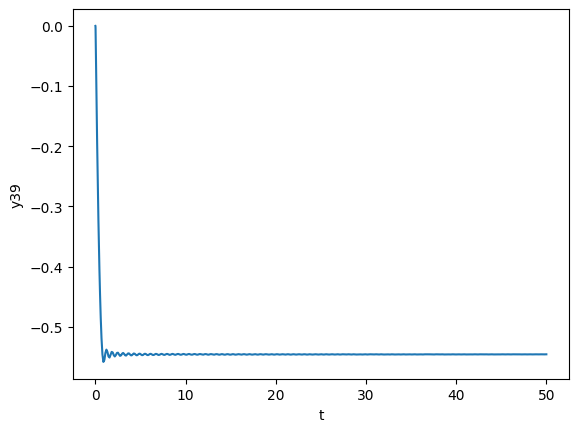

In [127]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

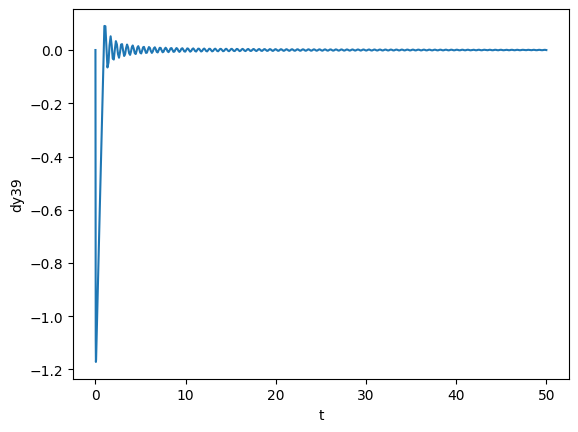

In [128]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

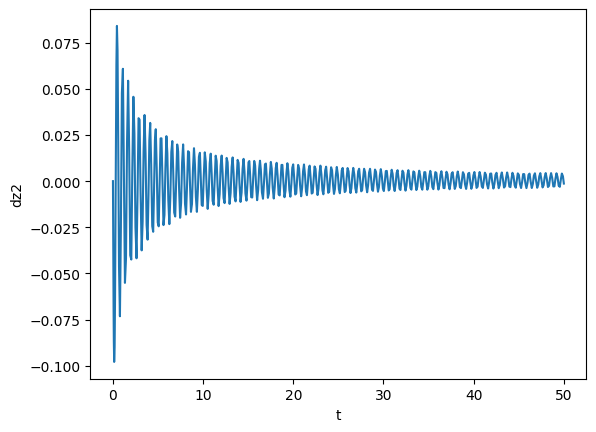

In [129]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

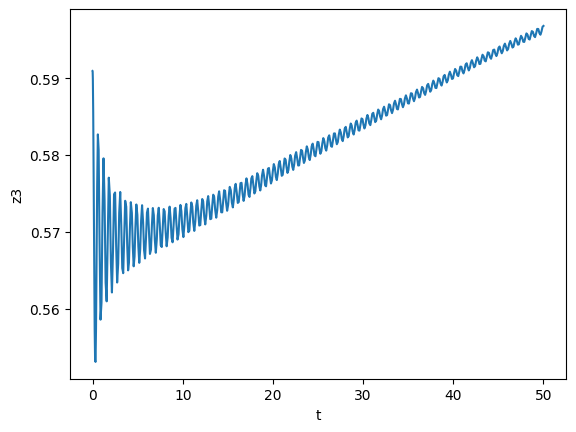

In [130]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

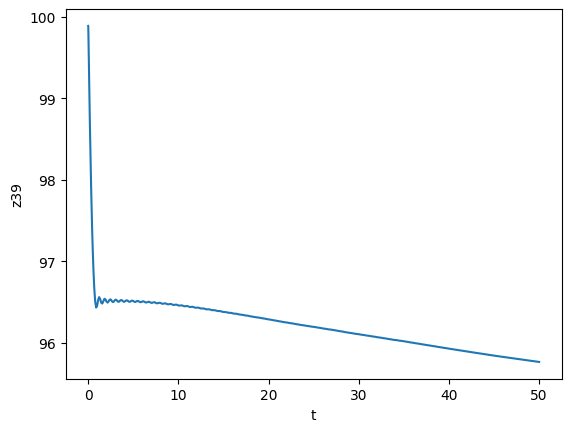

In [131]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

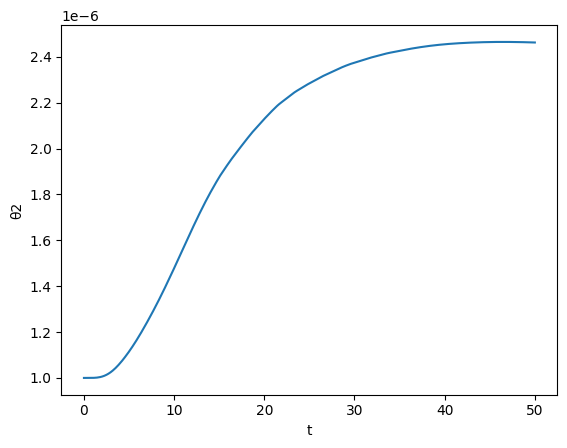

In [132]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

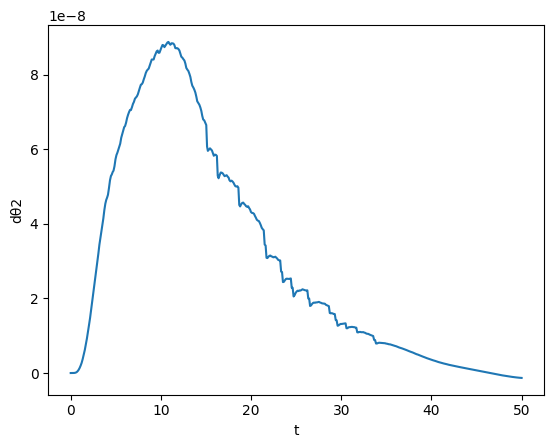

In [133]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

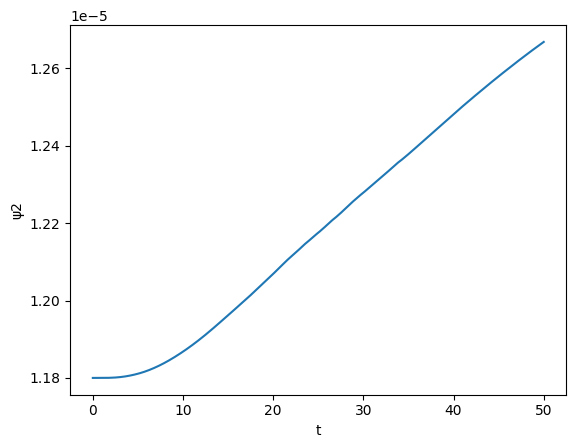

In [134]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

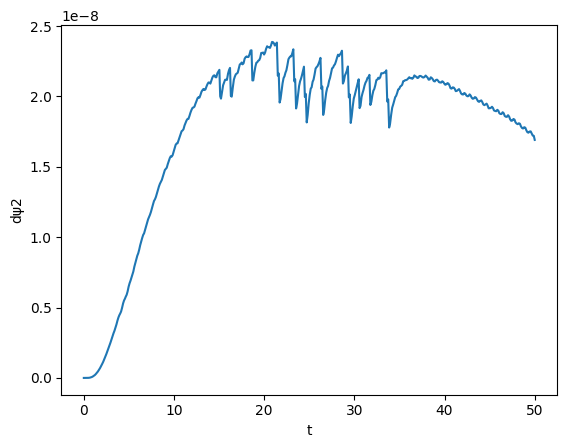

In [135]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

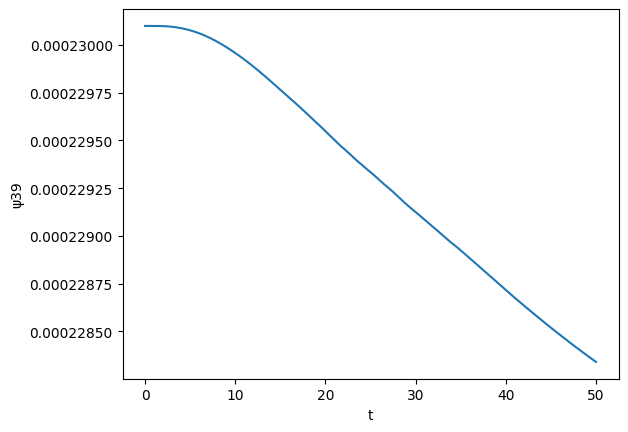

In [136]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()